In [1]:
from vectorbtpro import *

start_string = '2025-01-12 UTC'
end_string = '2025-01-13 UTC'
symbol_array = ['SOLUSDT']
timeframe_string = '1m'

vbt.BinanceData.set_custom_settings()
data = vbt.BinanceData.pull(
    symbol_array, 
    start=start_string,
    end=end_string,
    timeframe=timeframe_string,
    client_config=dict(tld="us")
)

In [2]:
leverage = 1
take_profit = 0.02
stop_loss = 0.01   # 3.3% stop loss
rsi_threshold = 75  # RSI overbought threshold
rsi_differential = -5
volume_threshold = 2.5  # Minimum volume for valid entry
exit_types = ["SL", "TP"]
open_price = data.get('Open')
close_price = data.get('Close')
volume_data = data.get('Volume')

In [3]:
rsi = vbt.RSI.run(close_price)

In [4]:
rsi_values = rsi.rsi

In [5]:
rsi_diff = rsi_values.diff()
rsi_diff

symbol,SOLUSDT
Open time,
2025-01-12 00:00:00+00:00,NaN
2025-01-12 00:01:00+00:00,NaN
2025-01-12 00:02:00+00:00,NaN
2025-01-12 00:03:00+00:00,NaN
2025-01-12 00:04:00+00:00,NaN
...,...
2025-01-12 23:55:00+00:00,2.842171e-14
2025-01-12 23:56:00+00:00,-1.421085e-14
2025-01-12 23:57:00+00:00,-1.421085e-14


In [6]:
entries = (rsi.rsi.shift(1) > rsi_threshold) & (rsi.rsi < 70) & (rsi_diff <= rsi_differential) # & (volume_data > volume_threshold)

In [7]:
sl_ohlcstx = vbt.OHLCSTX.run(
    entries,  
    entry_price=entries,  
    open=data.get("Open"), 
    high=data.get("High"), 
    low=data.get("Low"), 
    close=data.get("Close"), 
    sl_stop=stop_loss,  
    stop_type=None  
)
sl_exits = sl_ohlcstx.exits.copy()  
sl_price = sl_ohlcstx.close.copy()  
sl_price[sl_exits] = sl_ohlcstx.stop_price
del sl_ohlcstx 

In [8]:
tp_ohlcstx = vbt.OHLCSTX.run(
    entries, 
    entry_price=entries, 
    open=data.get("Open"), 
    high=data.get("High"), 
    low=data.get("Low"), 
    close=data.get("Close"), 
    tp_stop=take_profit,
    stop_type=None
)
tp_exits = tp_ohlcstx.exits.copy()
tp_price = tp_ohlcstx.close.copy()
tp_price[tp_exits] = tp_ohlcstx.stop_price
del tp_ohlcstx


In [9]:
# Example sl_exits and tp_exits (original DataFrames)
# Ensure they are already flattened
sl_exits_flat = sl_exits.droplevel(level=1, axis=1)  # Flatten if multi-level
tp_exits_flat = tp_exits.droplevel(level=1, axis=1)  # Flatten if multi-level

# Combine SL and TP into a single boolean Series
sl_tp_exits = (sl_exits_flat.any(axis=1) | tp_exits_flat.any(axis=1))

#print(sl_tp_exits)  # Boolean Series
clean_entries, clean_exits = entries.vbt.signals.clean(sl_tp_exits)

clean_entries.vbt.signals.total() 

symbol
SOLUSDT    16
Name: total, dtype: int64

In [10]:
portfolio = vbt.Portfolio.from_signals(
    close=close_price,
    entries=clean_entries,
    exits=clean_exits,  # Exits are handled by stop-loss and take-profit
    size=np.inf,              # Fully allocate
    init_cash=1000,           # Starting cash
    # fees=0.001,               # Transaction fees
    leverage=leverage,
    direction="shortonly"  # Short positions only
)


# Visualize Portfolio
#portfolio.plot().show()

In [11]:
# Analyze Portfolio
portfolio.stats()

Start Index                   2025-01-12 00:00:00+00:00
End Index                     2025-01-12 23:59:00+00:00
Total Duration                          1 days 00:00:00
Start Value                                      1000.0
Min Value                                    998.445005
Max Value                                   1000.693925
End Value                                     999.45225
Total Return [%]                              -0.054775
Benchmark Return [%]                           0.249867
Position Coverage [%]                          1.111111
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                               0.224736
Max Drawdown Duration                   0 days 21:20:00
Total Orders                                         32
Total Fees Paid                                     0.0
Total Trades                                         16
Win Rate [%]                                       12.5
Best Trade [%]                                 0

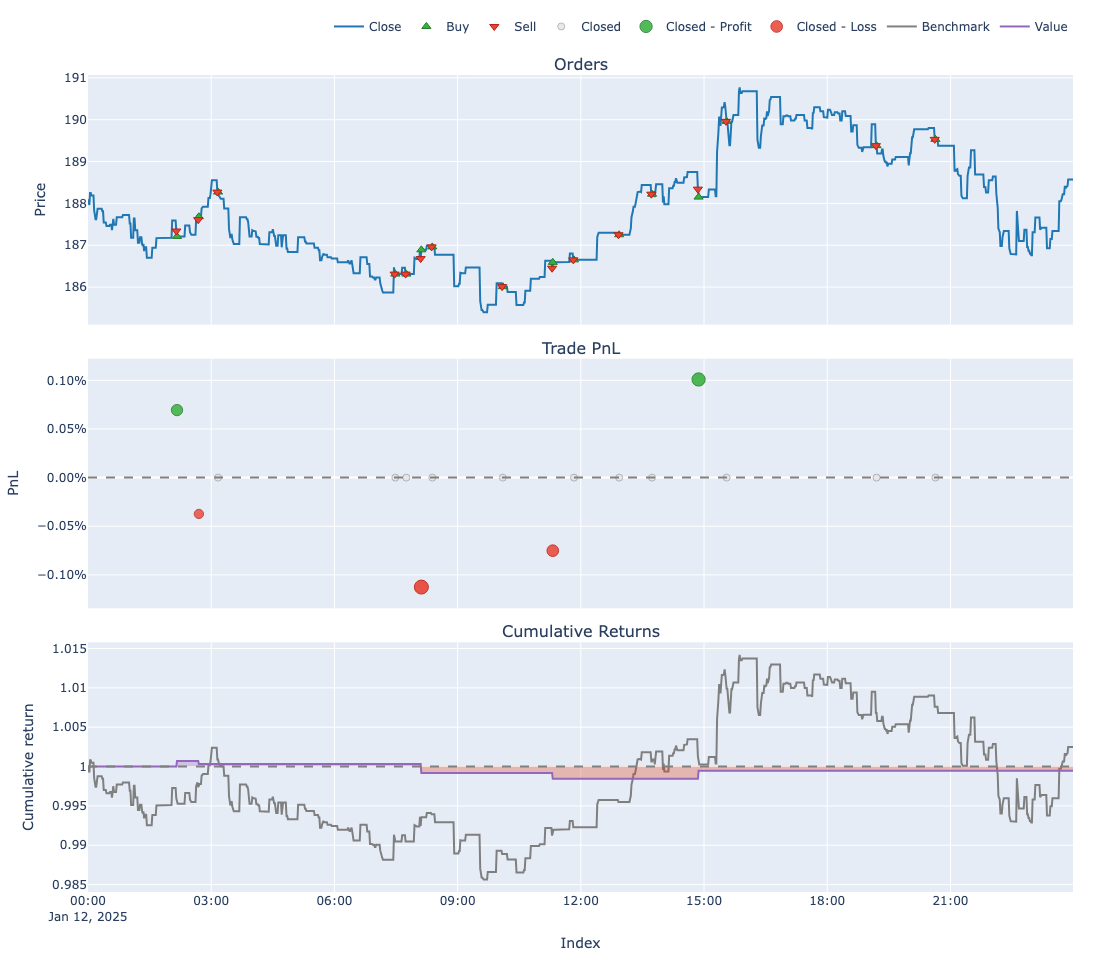

In [13]:
portfolio.plot().show()